# (12104) Chesley orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '12104'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_hires = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_mpc_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_hires, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_array_gaia, observer_codes_gaia = fit.get_gaia_optical_obs_array(body_id, t_min_tdb, t_max_tdb, gaia_dr, verbose)
    obs_array_optical = np.vstack((obs_array_optical, obs_array_gaia))
    observer_codes_optical = observer_codes_optical + observer_codes_gaia

Skipped 0 observations 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 3969 observations. Debiased 1301 observations. No biasing information for 10 observations.
Applied default weight of 1 arcsec to 248 CCD observations
Deweighted 867 observations as part of deweighting scheme.
Found 459 observations from gaiafpr
	 Added 459 of those observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.787			 16.249			 1997.045			 0.174
2			 0.785			 16.117			 2038.279			 0.178
3			 0.785			 16.117			 2038.354			 0.178
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.759			 16.117			 1702.389			 0.149
Converged after rejecting outliers. Rejected 23 out of 5739 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.7586404230627457
RMS weighted: 16.116532196321796
chi-squared: 1702.389221066087
reduced chi-squared: 0.14899258017382172
square root of reduced chi-squared: 0.385995570147925
--------------------------------------------------------------
Solution Time: MJD 57879.000 TDB = 2017-05-06 00:00:00.000 TDB
Solution Observation Arc: 17566.98 days (48.10 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			2.43306273471e-02		7.47205583241e-10 		2.43306273948e-02		5.33228610256e-10 		+4.76554490314e-11		+0.064
q			2.93727002330e+00		3.47578290213e-09 		2.93727006923e+00		2.55441184115e-09 		+4.59287186061e-08		+13.214
tp			5.87280740290e+04		6.89942006350e-06 		5.87280742724e+04		5.37489066028e-06 		+2.43452581344e-04		+35.286
om			7.80628592736e+01		1.29528319322e-07 		7.80628677697e+01		8.15521

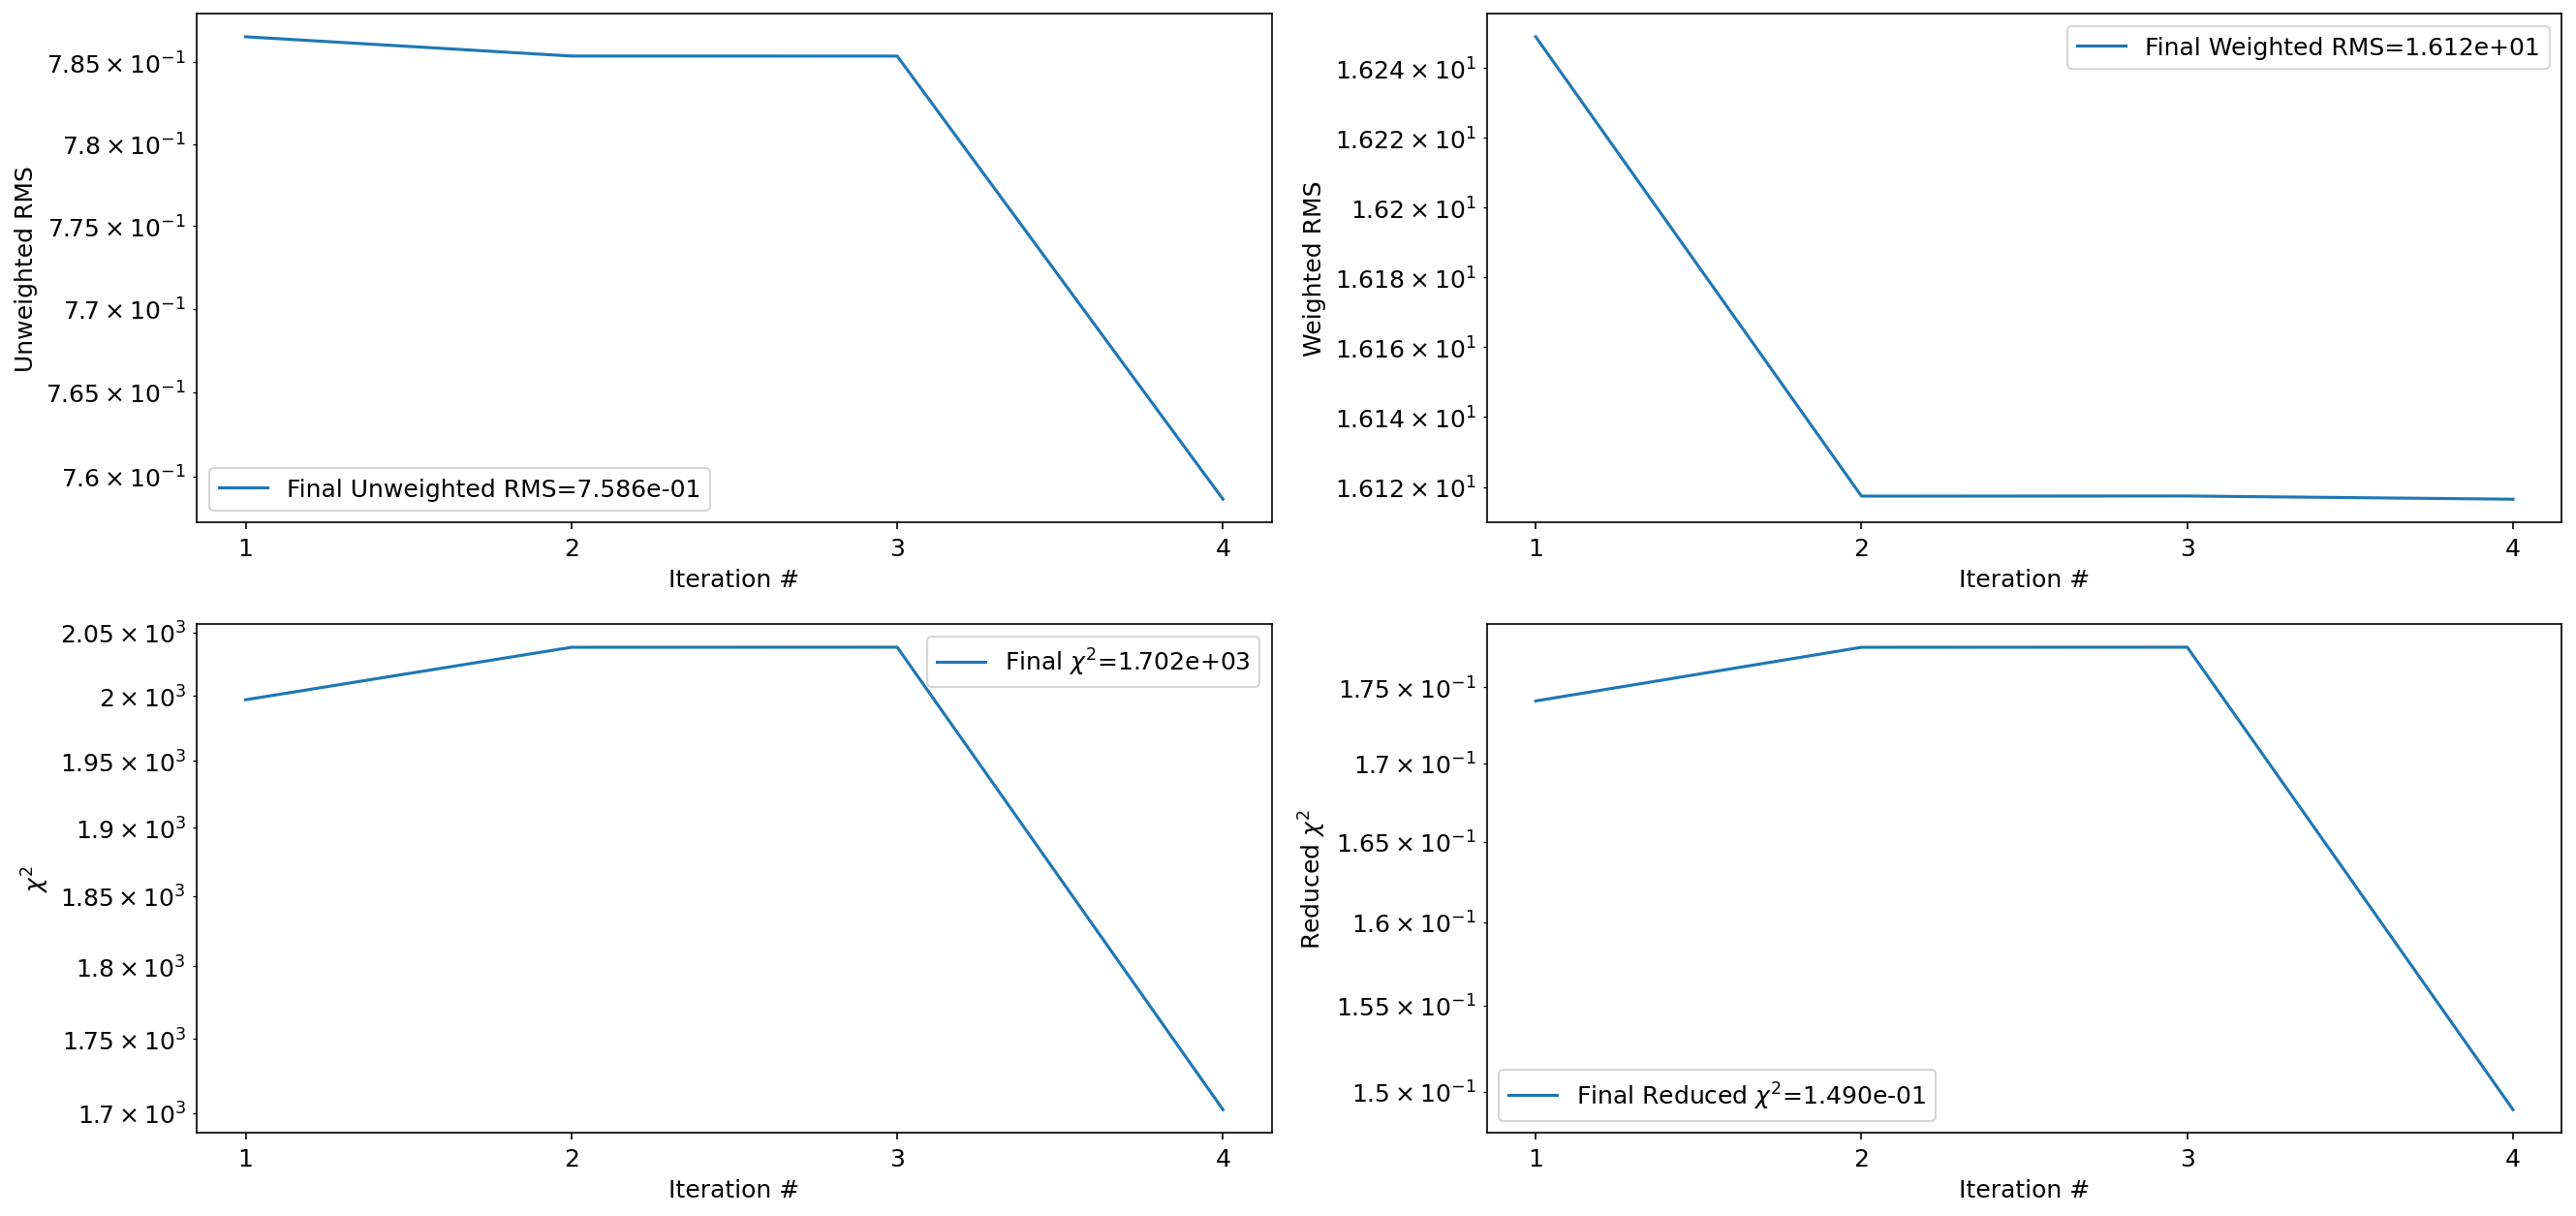

In [8]:
fit_sim.plot_summary(auto_close=True)

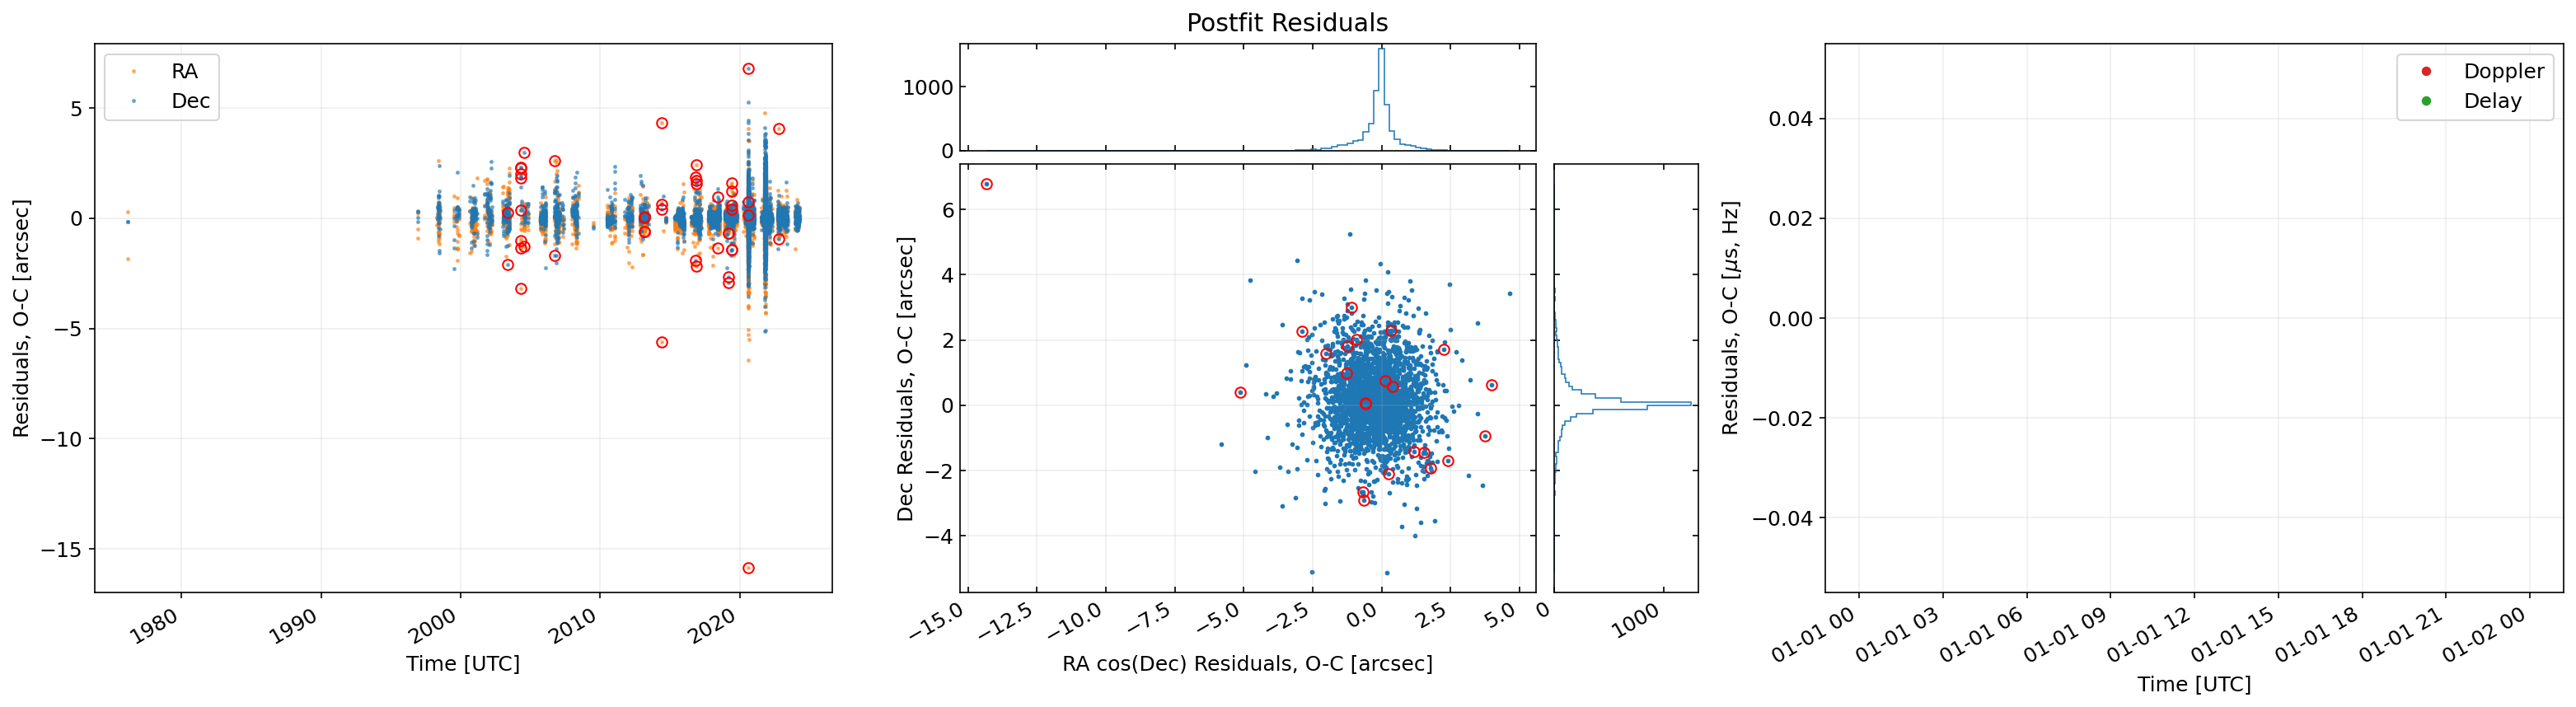

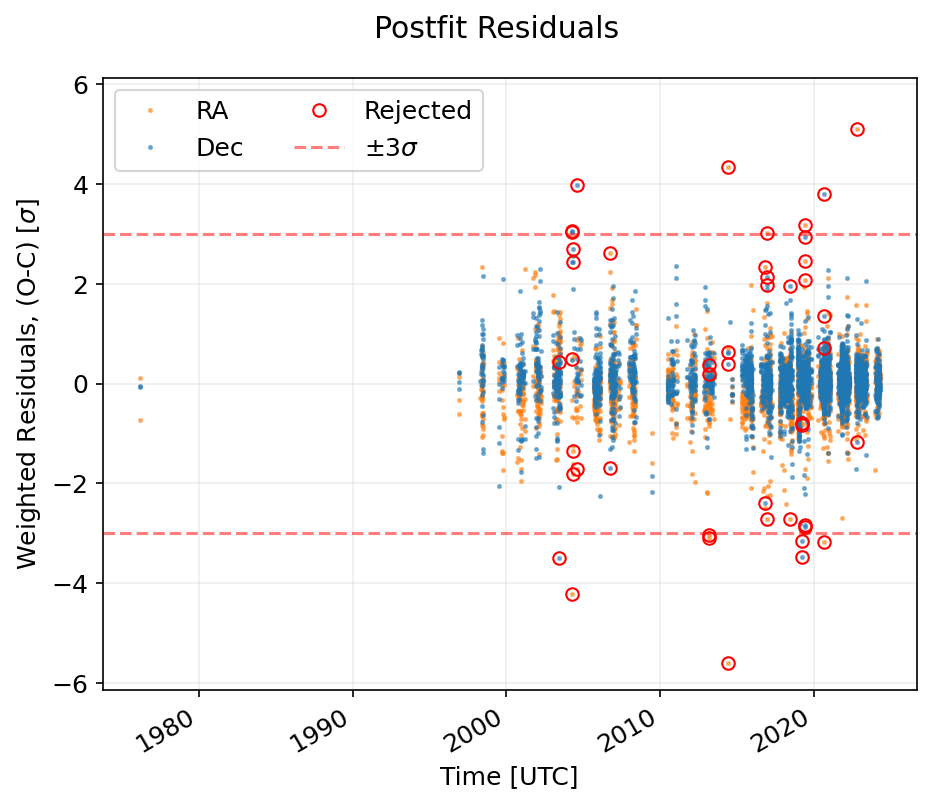

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 105.06
Mahalonobis distance between GRSS and JPL solution: 211.12
Bhattacharya distance between JPL and GRSS solution: 0.2864
Bhattacharya coefficient between JPL and GRSS solution: 0.7510


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90

AssertionError: 